In [1]:
import numpy as np
import json
import sys
import os
from pathlib import Path
import glob
import open3d as o3d
from collections import defaultdict
from os.path import abspath, relpath
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from opensfm import features
from opensfm.features import resized_image, normalize_features, extract_features, root_feature, extract_features_sift
from typing import Dict, List, Any, Tuple
from opensfm import dataset
import shutil
import bisect
from scipy.spatial.transform import Rotation, RotationSpline
from copy import deepcopy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def visualize_poses(poses, color=None, show_orientation=False):
    pose_vis = []
    if show_orientation:
        for pose in poses:
            new_vis = o3d.geometry.TriangleMesh.create_coordinate_frame(0.1).transform(pose)
            if color is not None:
                new_vis = new_vis.paint_uniform_color(color)
            pose_vis.append(new_vis)
    else:
        points = np.asarray([pose[0:3, 3] for pose in poses])
        cloud = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
        pose_vis.append(cloud)
    return pose_vis

def visualize_cameras(poses, cameras, color=None, scale=1.0):
    pose_vis = []
    for pose, camera in zip(poses, cameras):
        pinhole_camera = o3d.camera.PinholeCameraIntrinsic(camera.width, camera.height, camera.K)
        new_vis = o3d.geometry.LineSet.create_camera_visualization(pinhole_camera,
                                                                   np.eye(4),
                                                                   scale = scale).transform(pose)
        if color is not None:
            new_vis = new_vis.paint_uniform_color(color)
        pose_vis.append(new_vis)
    return pose_vis

In [3]:
def superEllipsePoses(a, b, n, z_height=1.85, boundary_threshold=0.3, fudge_factor=3.0, arc_length_step=0.05):
    # x=a|cost|2/nsgn(cost)
    # y=b|sint|2/nsgn(sint)t∈[0,2π]
    sample_positions = []
    sample_poses = []
    sample_times = []
    sample_tangents = []
    i = 0.0
    D = arc_length_step
    while i < 2*np.pi:
        theta = i
        x = a*np.abs(np.cos(theta))**(2.0/n)*np.sign(np.cos(theta))
        y = b*np.abs(np.sin(theta))**(2.0/n)*np.sign(np.sin(theta))
        z = z_height
        new_position = np.asarray([x,y,z])    
        sample_positions.append(new_position)

        dx_dt = (-2*a*np.sin(theta)*np.abs(np.cos(theta))**(2/(n-1)))/n
        dy_dt = (2*a*np.cos(theta)*np.abs(np.sin(theta))**(2/(n-1)))/n

        sample_tangents.append([dx_dt, dy_dt])

        gamma = boundary_threshold
        if np.abs(i) < gamma:
            delta_i = np.abs(np.abs((D/b - i**(2/n)))**(n/2) - i) *fudge_factor
            i = delta_i + i
            # print("regime: 0")
            # print(f"delta_i: {delta_i}")
        elif np.abs(i - np.pi/2) < gamma:
            delta_i = np.abs(np.abs(D/a - (np.abs(np.pi/2 - i))**(2/n))**(n/2) - np.abs(np.pi/2 - i))*fudge_factor
            i = delta_i + i
            # print("regime: pi/2")
            # print(f"delta_i: {delta_i}")
        elif np.abs(i - np.pi) < gamma:
            delta_i = np.abs(np.abs(D/b - (np.abs(np.pi - i))**(2/n))**(n/2) - np.abs(np.pi - i))*fudge_factor
            i = delta_i + i
            # print("regime: pi")
            # print(f"delta_i: {delta_i}")
        elif np.abs(i - 3*np.pi/2) < gamma:
            delta_i = np.abs(np.abs(D/a - (np.abs(3*np.pi/2 - i))**(2/n))**(n/2) - np.abs(3*np.pi/2 - i))*fudge_factor
            i = delta_i + i
            # print("regime: 3pi/2")
            # print(f"delta_i: {delta_i}")
        elif np.abs(i - 4*np.pi/2) < gamma:
            delta_i = np.abs(np.abs(D/a - (np.abs(4*np.pi/2 - i))**(2/n))**(n/2) - np.abs(4*np.pi/2 - i))*fudge_factor
            i = delta_i + i
            # print("regime: 2pi")
            # print(f"delta_i: {delta_i}")
        else:
            delta_i = D/(np.sqrt((dx_dt**2) + (dy_dt**2)))
            i = delta_i + i
            # print("regime: free")
            # print(f"delta_i: {delta_i}")

    for i in range(len(sample_positions)):
        normalized_position = sample_positions[i][0:2] / np.linalg.norm(sample_positions[i][0:2])
        theta = np.arccos(np.dot(np.asarray([1.0, 0.0]), normalized_position)) * np.sign(normalized_position[-1])
        new_rot = Rotation.from_rotvec(1*np.asarray([0.0, 0.0, 1.0])*theta).as_matrix()
        new_pose = np.eye(4)
        new_pose[0:3, 0:3] = new_rot
        new_pose[0:3, 3] = sample_positions[i]
        sample_poses.append(new_pose)
        sample_times.append(i/len(sample_positions))
    return sample_times, sample_poses

In [4]:
def interpolate_poses(pose_timestamps, abs_poses, requested_timestamps):
    """Interpolate between absolute poses.
    Args:
        pose_timestamps (list[int]): Timestamps of supplied poses. Must be in ascending order.
        abs_poses (list[numpy.matrix]): SE3 matrices representing poses at the timestamps specified.
        requested_timestamps (list[int]): Timestamps for which interpolated timestamps are required.
    Returns:
        list[numpy.matrixlib.defmatrix.matrix]: SE3 matrix representing interpolated pose for each requested timestamp.
    Raises:
        ValueError: if pose_timestamps and abs_poses are not the same length
        ValueError: if pose_timestamps is not in ascending order
    """

    abs_rot = [pose[0:3, 0:3] for pose in abs_poses]
    rotation_spline = RotationSpline(pose_timestamps, Rotation.from_matrix(abs_rot))
    requested_rotations = rotation_spline(requested_timestamps)

    requested_timestamps = np.array(requested_timestamps)
    pose_timestamps = np.array(pose_timestamps)
    if len(pose_timestamps) != len(abs_poses):
        raise ValueError('Must supply same number of timestamps as poses')

    upper_indices = [bisect.bisect(pose_timestamps, pt) for pt in requested_timestamps]
    lower_indices = [u - 1 for u in upper_indices]

    if max(upper_indices) >= len(pose_timestamps):
        upper_indices = [min(i, len(pose_timestamps) - 1) for i in upper_indices]

    # print(upper_indices)
    # print(lower_indices)

    fractions = (requested_timestamps - pose_timestamps[lower_indices]) / \
                (pose_timestamps[upper_indices] - pose_timestamps[lower_indices])

    fractions[np.isnan(fractions)] = 1.0 # nan indicate zero denom

    # print(fractions)

    requested_positions = []
    for i in range(0, len(requested_timestamps)):
        fraction = fractions[i]
        lower_pos = abs_poses[lower_indices[i]][0:3, 3]
        upper_pos = abs_poses[upper_indices[i]][0:3, 3]

        new_pos = fraction * upper_pos + (1-fraction)*lower_pos
        requested_positions.append(new_pos)

    output_poses = []
    for rot, pos in zip(requested_rotations, requested_positions):
        new_pose = np.eye(4)
        new_pose[0:3, 0:3] = rot.as_matrix()
        new_pose[0:3, 3] = pos
        output_poses.append(new_pose)
    return output_poses

In [5]:
class Waypoint:
    def __init__(self, timestamp, T_world_from_cam):
        self.timestamp = timestamp
        self.T_world_from_cam = T_world_from_cam

class Trajectory:
    def __init__(self, waypoints: List[Waypoint]):
        self.waypoints = sorted(waypoints, key = lambda x : x.timestamp)
        self.mintime = self.waypoints[0].timestamp
        self.maxtime = self.waypoints[-1].timestamp
        self.normalized_times = [(waypoint.timestamp - self.mintime)/(self.maxtime - self.mintime) for waypoint in self.waypoints]
        self.poses = [waypoint.T_world_from_cam for waypoint in waypoints]
    def getPoseAtTime(self, time):
        normalized_time = (time - self.mintime)/(self.maxtime - self.mintime)
        return getPoseAtNormalizedTime(normalized_time)
    def getPoseAtNormalizedTime(self, normalized_time):
        # TODO: use SE3 interpolation
        # For now, interpolate SO3, and R3
        poses = interpolate_poses(self.normalized_times, self.poses, [normalized_time])
        return poses[0]
        
    @staticmethod
    def superEllipseTrajectory(a=1.0, b=1.0, n=4,  z_height=1.85, boundary_threshold=0.3, fudge_factor=3.0, arc_length_step=0.05):
        sample_times, sample_poses = superEllipsePoses(a, b, n, z_height, boundary_threshold, fudge_factor, arc_length_step)
        return Trajectory([Waypoint(timestamp, pose) for timestamp, pose in zip(sample_times, sample_poses)])

    @staticmethod
    def stereoTrajectory(baseline=1.0, angle_degrees_cam_left=45.0, angle_degrees_cam_right=-45.0):
        half_baseline = baseline/2
        rotation_left = Rotation.from_rotvec(np.asarray([0.0, 1.0, 0.0])*angle_degrees_cam_left*np.pi/180.0).as_matrix()
        rotation_right = Rotation.from_rotvec(np.asarray([0.0, 1.0, 0.0])*angle_degrees_cam_right*np.pi/180.0).as_matrix()
        
        T_world_from_cam_left = np.eye(4)
        T_world_from_cam_left[0:3, 0:3] = rotation_left
        T_world_from_cam_left[0:3, 3] = np.asarray([-half_baseline, 0.0, 0.0])

        T_world_from_cam_right = np.eye(4)
        T_world_from_cam_right[0:3, 0:3] = rotation_right
        T_world_from_cam_right[0:3, 3] = np.asarray([half_baseline, 0.0, 0.0])

        sample_poses = [T_world_from_cam_left, T_world_from_cam_right]
        sample_times = [0.0, 1.0]
        
        return Trajectory([Waypoint(timestamp, pose) for timestamp, pose in zip(sample_times, sample_poses)])
    
    def transform(self, prefix_matrix, postfix_matrix):
        new_waypoints = [Waypoint(wp.timestamp, np.matmul(prefix_matrix, np.matmul(wp.T_world_from_cam, postfix_matrix))) for wp in self.waypoints]
        new_trajectory = Trajectory(new_waypoints)
        return new_trajectory
        

In [6]:
class Geometry:
    def __init__(self, mesh: o3d.geometry.TriangleMesh):
        self.mesh = mesh
    def sample(self, n_samples):
        sample_cloud = self.mesh.sample_points_uniformly(n_samples)
        points = np.asarray(sample_cloud.points)
        colors = np.asarray(sample_cloud.colors)*255
        colors = colors.astype(np.uint8)
        return points, colors

class Scene:
    def __init__(self, geometries: List[Geometry]):
        self.geometries = geometries
    def sample(self, n_samples):
        n_samples_per_scene = int(n_samples / len(self.geometries))
        print(f"samples_per_scene : {n_samples_per_scene}")
        samples = []
        for geometry in self.geometries:
            samples.append(geometry.sample(n_samples_per_scene))
        return samples
    def getVisualization(self):
        vis = []
        for geom in self.geometries:
            vis.append(geom.mesh)
        return vis
    def getSampledVisualization(self, n_samples):
        samples = self.sample(n_samples)
        points = []
        colors = []

        for sample in samples:
            points_i, colors_i = sample[0], sample[1]
            points.append(points_i)
            colors.append(colors_i)
        points = np.vstack(points)
        colors = np.vstack(colors)
        colors = colors.astype(float) / 255.0

        # print(points.shape)
        new_cloud = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
        new_cloud.colors = o3d.utility.Vector3dVector(colors)
        vis = [new_cloud]
        return vis

    @staticmethod
    def RectangularScene(width, height, depth):
        geometries = []
        half_width = width / 2
        half_depth = depth / 2

        # create 5 bounded planes
        # floor plane, n = [0.0, 0.0, 1.0], tl = [-hw, hd, 0.0], tr = [hw, hd, 0.0], br = [hw, -hd, 0.0], bl = [-hw, -hd, 0.0]
        floor_bounded_plane = ru.BoundedPlane(a=0.0, b=0.0, c=1.0, d=0.0,
                                              top_left=[-half_width, half_depth, 0.0],
                                              top_right=[half_width, half_depth, 0.0],
                                              bottom_right=[half_width, -half_depth, 0.0],
                                              bottom_left=[-half_width, -half_depth, 0.0],
                                              name="floor_plane")
        left_bounded_plane = ru.BoundedPlane(a=1.0, b=0.0, c=0.0, d=-half_width,
                                              top_left=[-half_width, -half_depth, height],
                                              top_right=[-half_width, half_depth, height],
                                              bottom_right=[-half_width, half_depth, 0.0],
                                              bottom_left=[-half_width, -half_depth, 0.0],
                                              name="left_plane")

        right_bounded_plane = ru.BoundedPlane(a=-1.0, b=0.0, c=0.0, d=-half_width,
                                              top_left=[half_width, -half_depth, height],
                                              top_right=[half_width, half_depth, height],
                                              bottom_right=[half_width, half_depth, 0.0],
                                              bottom_left=[half_width, -half_depth, 0.0],
                                              name="right_plane")
        front_bounded_plane = ru.BoundedPlane(a=0.0, b=-1.0, c=0.0, d=-half_depth,
                                              top_left=[-half_width, half_depth, height],
                                              top_right=[half_width, half_depth, height],
                                              bottom_right=[half_width, half_depth, 0.0],
                                              bottom_left=[-half_width, half_depth, 0.0],
                                              name="front_plane")
        back_bounded_plane = ru.BoundedPlane(a=0.0, b=1.0, c=0.0, d=-half_depth,
                                              top_left=[-half_width, -half_depth, height],
                                              top_right=[half_width, -half_depth, height],
                                              bottom_right=[half_width, -half_depth, 0.0],
                                              bottom_left=[-half_width, -half_depth, 0.0],
                                              name="back_plane")
        geometries.append(Geometry(floor_bounded_plane.get_open3d_mesh().paint_uniform_color([0.0, 0.0, 1.0])))
        geometries.append(Geometry(left_bounded_plane.get_open3d_mesh().paint_uniform_color([1.0, 0.0, 1.0])))
        geometries.append(Geometry(right_bounded_plane.get_open3d_mesh().paint_uniform_color([1.0, 0.0, 0.0])))
        geometries.append(Geometry(front_bounded_plane.get_open3d_mesh().paint_uniform_color([0.0, 1.0, 0.0])))
        geometries.append(Geometry(back_bounded_plane.get_open3d_mesh().paint_uniform_color([0.0, 1.0, 1.0])))
        return Scene(geometries)

    @staticmethod
    def BallScene():
        geometries = []
        center_ball_transform = np.asarray([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 4.0 ], [0.0, 0.0, 1.0, 2.0], [0.0, 0.0, 0.0, 1.0]])
        left_ball_transform = np.asarray([[1.0, 0.0, 0.0, -3.0], [0.0, 1.0, 0.0, 4.0 ], [0.0, 0.0, 1.0, 3.0], [0.0, 0.0, 0.0, 1.0]])
        right_ball_transform = np.asarray([[1.0, 0.0, 0.0, 3.0], [0.0, 1.0, 0.0, 4.0 ], [0.0, 0.0, 1.0, 3.0], [0.0, 0.0, 0.0, 1.0]])
        left_ball = o3d.geometry.TriangleMesh.create_sphere(radius=0.75).transform(left_ball_transform)
        right_ball = o3d.geometry.TriangleMesh.create_sphere(radius=1.0).transform(right_ball_transform)
        center_ball = o3d.geometry.TriangleMesh.create_sphere(radius=2.0).transform(center_ball_transform)
        
        geometries.append(Geometry(center_ball.paint_uniform_color([1.0, 0.0, 0.0])))
        geometries.append(Geometry(left_ball.paint_uniform_color([0.0, 1.0, 0.0])))
        geometries.append(Geometry(right_ball.paint_uniform_color([0.0, 0.0, 1.0])))
        return Scene(geometries)
        
        

In [38]:
class Point2D:
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id
    def as_array(self):
        return np.asarray([self.x, self.y])

class Point3D:
    def __init__(self, x, y, z, id):
        self.x = x
        self.y = y
        self.z = z
        self.id = id
    def as_array(self):
        return np.asarray([self.x, self.y, self.z])

class Color:
    def __init__(self, r, g, b):
        self.r = r
        self.g = g
        self.b = b
    def as_array(self):
        return np.asarray([self.r, self.g, self.b])

class Observation:
    def __init__(self, track_id, observation_id, point: Point2D, color: Color):
        self.track_id = track_id
        self.observation_id = observation_id
        self.point = point
        self.color = color
    def as_array(self):
        return self.point.as_array()


def draw_observations(observations: List[Observation], width, height):
    img = np.ones((height, width, 3), dtype=np.uint8)*255
    for observation in observations:
        x = observation.point.x
        y = observation.point.y
        u = int(np.floor(x))
        v = int(np.floor(y))
        if ((u < 0) or (v < 0)):
            continue
        if ((u >= width) or (v >= height)):
            continue
        img[v, u] = np.asarray([observation.color.r, observation.color.g, observation.color.b])
    return img


class Camera:
    def __init__(self, K, distortion, width, height, pixel_noise=0.0):
        self.K = K
        self.distortion = distortion
        self.width = width
        self.height = height
        self.pixel_noise = pixel_noise

    def render(self, points3d: List[Point3D], colors: List[Color], T_world_from_cam, shot_id:str)->List[Observation]:
        T_cam_from_world = np.linalg.inv(T_world_from_cam)
        r_vec = Rotation.from_matrix(T_cam_from_world[0:3, 0:3]).as_rotvec()
        t_vec = T_cam_from_world[0:3, 3]

        points3d_array = np.vstack([point.as_array() for point in points3d])
        print(f"len points_3d_array: {len(points3d_array)}")
        points2d_array, _ = cv2.projectPoints(
        points3d_array,
        r_vec,
        t_vec,
        self.K,
        np.asarray(self.distortion))
        points2d_array = np.squeeze(points2d_array)
        points2d_array += np.random.normal(0.0, self.pixel_noise, points2d_array.shape)
        print(f"len points2_array: {len(points2d_array)}")

        points3d_array_in_cam = np.matmul(T_cam_from_world[0:3, 0:3], points3d_array.T).T + T_cam_from_world[0:3, 3]

        observations = []
        obs_count = 0
        for point2d_vector, point3d, point3d_in_cam, color in zip(points2d_array, points3d, points3d_array_in_cam, colors):
            if point3d_in_cam[-1] > 0.0:
                new_obs = Observation(point3d.id,
                                      (shot_id,  obs_count),
                                      Point2D(point2d_vector[0], point2d_vector[1], obs_count),
                                      color)
                obs_count += 1
                observations.append(new_obs)
        print(f"len observations: {len(observations)}")
        return observations
    
class Frame:
    def __init__(self, shot_id, observations, camera):
        self.observations = observations
        self.K = camera.K
        self.distortion = camera.distortion
        self.shot_id = shot_id
        self.width = camera.width
        self.height = camera.height
        self.undistorted_observations = self.compute_undistorted_observations()
        self.T_world_from_cam_estimate = None
        self.gt_T_world_from_cam = None

    def compute_undistorted_observations(self):
        distorted_points_as_array = np.asarray([obs.as_array() for k, obs in self.observations.items()])
        observation_keys = list(self.observations.keys())

        # print(f"distorted_points: \n {distorted_points_as_array[0:5, :]}")
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(self.K, self.distortion, (self.width,self.height), 1, (self.width,self.height)) # w,h is the image shape
        undistorted_points = cv2.undistortPoints(distorted_points_as_array.reshape((-1, 1, 2)),self.K, self.distortion, None, newcameramtx)
        undistorted_points = np.squeeze(undistorted_points)

        # print(f"undistorted_points: \n {undistorted_points[0:5, :]}")


        undistorted_obs  = {}
        for k, undistorted_pixel in zip(observation_keys, undistorted_points):
            new_observation = deepcopy(self.observations[k])
            new_observation.point = Point2D(undistorted_pixel[0], undistorted_pixel[1], k)
            undistorted_obs[k] = new_observation
        return undistorted_obs

    def get_visualization(self, scale=0.1):
        if self.T_world_from_cam_estimate is None:
            return []
        else:
            pinhole_camera = o3d.camera.PinholeCameraIntrinsic(self.width, self.height, self.K)
            frame_vis = o3d.geometry.LineSet.create_camera_visualization(pinhole_camera,
                                                                         np.eye(4),
                                                                         scale = scale).transform(self.T_world_from_cam_estimate)
            return [frame_vis]
    def get_visualization_gt(self, scale=0.1, color=[1.0, 0.0, 0.0]):
        if self.gt_T_world_from_cam is None:
            return []
        else:
            pinhole_camera = o3d.camera.PinholeCameraIntrinsic(self.width, self.height, self.K)
            frame_vis = o3d.geometry.LineSet.create_camera_visualization(pinhole_camera,
                                                                         np.eye(4),
                                                                         scale = scale).transform(self.gt_T_world_from_cam).paint_uniform_color(color)
            return [frame_vis]
        
# def triangulate(list_of_observations_matrices, list_of_projection_matrices):
#     points = [elem.T for elem in list_of_observations_matrices]
#     points_3d = cv2.triangulatePoints(points, list_of_projection_matrices)
#     return points_3d.T

def triangulate(points_2d_array_1, K_1, T_world_from_cam_1, points_2d_array_2, K_2, T_world_from_cam_2):
    T_cam_from_world_1 = np.linalg.inv(T_world_from_cam_1)
    T_cam_from_world_2 = np.linalg.inv(T_world_from_cam_2)

    camera_projection_matrix_1 = np.matmul(K_1, T_cam_from_world_1[0:3, :])
    camera_projection_matrix_2 = np.matmul(K_2, T_cam_from_world_2[0:3, :])
    
    points_3d_homogenous = cv2.triangulatePoints(camera_projection_matrix_1, camera_projection_matrix_2, points_2d_array_1.T, points_2d_array_2.T)
    cartesian_points = (points_3d_homogenous[:3, :] / points_3d_homogenous[3, :]).T
    return cartesian_points

def get_matches(frame_1, frame_2, probability_of_mismatch=0.0):
    track_id_to_undistorted_observation_map_1 = {v_a.track_id: v_a for obs_id, v_a in frame_1.undistorted_observations.items()}
    track_id_to_undistorted_observation_map_2 = {v_a.track_id: v_a for obs_id, v_a in frame_2.undistorted_observations.items()}

    matched_track_ids = set(track_id_to_undistorted_observation_map_1.keys()).intersection(set(track_id_to_undistorted_observation_map_2.keys()))
    matched_track_ids = list(matched_track_ids)

    matches = [(track_id_to_undistorted_observation_map_1[track_id].observation_id,
                track_id_to_undistorted_observation_map_2[track_id].observation_id) for track_id in matched_track_ids]

    # if non zero probability of mismatch, randomly flip some indices
    p_sampled = np.ones((len(matches), ), dtype=float)*probability_of_mismatch
    n_samples = int(np.floor(len(matches)*probability_of_mismatch))
    indices = list(range(len(matches)))
    if n_samples > 0:
        samples_to_flip = np.random.choice(indices, n_samples, replace=False, p=p_sampled)
        for sample in samples_to_flip:
            random_idx = np.random.choice(indices, 1)
            matches[sample] = (matches[sample][0], matches[random_idx][1])
    return matches
    

def triangulate_frames(frame_1, T_world_from_cam_1, frame_2, T_world_from_cam_2, mask=None):
    matches = get_matches(frame_1, frame_2)
    if mask is not None:
        matches = [m for i, m in eneumerate(matches) if mask[i] == True]
    
    match_points_1 = np.asarray([frame_1.undistorted_observations[k[0]].as_array() for k in matches])
    match_points_2 = np.asarray([frame_2.undistorted_observations[k[1]].as_array() for k in matches])

    return triangulate(match_points_1, frame_1.K, T_world_from_cam_1, match_points_2, frame_2.K, T_world_from_cam_2), matches


def draw_matches(frame_1: Frame, frame_2: Frame, img1, img2, max_matches=None):
    matches = get_matches(frame_1, frame_2)
    cv_points_1 = [cv2.KeyPoint(frame_1.undistorted_observations[k[0]].point.x,frame_1.undistorted_observations[k[0]].point.y, 1.0 )  for k in matches]
    cv_points_2 = [cv2.KeyPoint(frame_2.undistorted_observations[k[1]].point.x,frame_2.undistorted_observations[k[1]].point.y, 1.0 )  for k in matches]
    if max_matches is None:
        max_matches = len(matches)
    cv_matches = [cv2.DMatch(i, i, 1.0) for i in range(min(len(matches), max_matches))]
    # print(f"len matches: {len(cv_matches)}")
    # print([[cv_point.pt] for cv_point in cv_points_1])
    img = cv2.drawMatches(img1, cv_points_1, img2, cv_points_2,cv_matches, None, 5, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return img
    
    
    

def estimate_pose_essential_matrix(frame_1: Frame, frame_2: Frame, scale):

    matches = get_matches(frame_1, frame_2)
    if len(matches) < 8:
        raise Exception(f"Too few matches between frames: {len(matches)}")

    match_points_1 = np.asarray([frame_1.undistorted_observations[k[0]].as_array() for k in matches])
    match_points_2 = np.asarray([frame_2.undistorted_observations[k[1]].as_array() for k in matches])
    E, mask = cv2.findEssentialMat(match_points_1, match_points_2, cameraMatrix=frame_1.K)
    # print(f"Essential Matrix results: {E}")
    # S = cv2.decomposeEssentialMat(E)

    # # figure out right R1, R2, and t
    # R1 = S[0]
    # R2 = S[1]
    # t = S[2]

    # n_positive_z = -1
    # best_T_world_from_cam = None
    # for i in range(4):
    #     T_cam_from_world = np.eye(4)
    #     if i == 0:
    #         T_cam_from_world[0:3, 0:3] = R1
    #         T_cam_from_world[0:3, 3] = t.reshape((3,))
    #     elif i == 1:
    #         T_cam_from_world[0:3, 0:3] = R1
    #         T_cam_from_world[0:3, 3] = -t.reshape((3,))
    #     elif i == 2:
    #         T_cam_from_world[0:3, 0:3] = R2
    #         T_cam_from_world[0:3, 3] = t.reshape((3,))
    #     else:
    #         T_cam_from_world[0:3, 0:3] = R2
    #         T_cam_from_world[0:3, 3] = -t.reshape((3,))

    #     camera_projection_matrix_1 = np.matmul(frame_1.K, np.eye(4)[0:3, :])
    #     camera_projection_matrix_2 = np.matmul(frame_2.K, T_cam_from_world[0:3, :])
    #     points_3d, _ = triangulate_frames(frame_1, np.eye(4), frame_2, np.linalg.inv(T_cam_from_world))

    #     n_pos_z = np.sum(points_3d[:, 2] > 0)
    #     n_pos_z += np.sum((np.matmul(T_cam_from_world[0:3, 0:3], points_3d.T).T + T_cam_from_world[0:3, 3])[:, 2] > 0)
    #     if n_pos_z > n_positive_z:
    #         best_T_world_from_cam = np.linalg.inv(T_cam_from_world)
    #         n_positive_z = n_pos_z
    inliers1 = match_points_1[mask]
    inliers2 = match_points_2[mask]
    n_positive_z, R_2_from_1, t_2_from_1, _ = cv2.recoverPose(E, inliers1, inliers1, frame_1.K)
    best_T_cam_from_world = np.eye(4)
    best_T_cam_from_world[0:3, 0:3] = R_2_from_1
    best_T_cam_from_world[0:3, 3] = t_2_from_1.reshape((3,))*scale
    best_T_world_from_cam = np.linalg.inv(best_T_cam_from_world)
    return best_T_world_from_cam, n_positive_z, matches, mask, inliers1, inliers2


def estimate_pose_pnp_ransac(points_3d: Dict, frame: Frame, inlier_threshold=0.3):
    undistorted_observations = frame.undistorted_observations
    track_id_to_obs_map = {obs.track_id : obs for obs in undistorted_obs}
    matches = [k for k in undistorted_observations if k in track_id_to_obs_map]
    if len(matches < 4):
        raise Exception(f"Too few matches between frame and map to proceed with pNp: {len(matches)}")
    points_3d_array = np.asarray([point_3d[k].as_array() for k in matches])
    points_2d_array = np.asarray([track_id_to_obs_map[k].point.as_array() for k in matches])
    (retval,
     rvec_cam_from_world,
     tvec_cam_from_world,
     inliers) = cv2.solvePnPRansac(points_3d_array, points_2d_array, frame.K, np.asarray([0.0, 0.0, 0.0, 0.0]))
    T_cam_from_world = np.eye(4)
    T_cam_from_world[0:3, 3] = tvec_cam_from_world
    T_cam_from_world[0:3, 0:3] = Rotation.from_rotvec(rvec_cam_from_world).as_matrix()
    T_world_from_cam = np.linalg.inv(T_cam_from_world)
    track_ids = list(track_id_to_obs_map.values())
    inlier_tracks = [track_ids[i] for i in inliers]
    return T_world_from_cam, len(inliers), inlier_tracks 
    
    


class Map:
    def __init__(self, frame_a, frame_b, scale=None, T_world_from_cam_0=None):
        self.observations = {}
        self.undistorted_observations = {}
        self.points = {}
        self.colors = {}
        self.frames = {}
        self.poses = {}
        self.T_world_from_cam_0 = T_world_from_cam_0
        self.scale = scale
        self.initialize(frame_a, frame_b)

    def initialize(self, frame_1, frame_2):
        # try to estimate transform using epipolar constraint
        # the triangulate
        T_world_from_cam_frame_2, n_positive_z, matches, mask, inliers1, inliers2 = estimate_pose_essential_matrix(frame_1, frame_2, scale=self.scale)
        T_cam_from_world_frame_2 = np.linalg.inv(T_world_from_cam_frame_2)
        self.poses[frame_1.shot_id] = np.eye(4)
        self.poses[frame_2.shot_id] = T_world_from_cam_frame_2
        # print(f"n_positive_z: {n_positive_z}")

        # matches = [k for k, v_a in frame_1.undistorted_observations.items() if k in frame_2.undistorted_observations]
        # if len(matches) < 8:
        #     raise Exception(f"Too few matches between frames: {len(matches)}")
        
        # match_points_1 = np.asarray([frame_1.undistorted_observations[k].as_array() for k in matches])
        # match_points_2 = np.asarray([frame_2.undistorted_observations[k].as_array() for k in matches])

        if mask is not None:
            matches = [m for i, m in enumerate(matches) if mask[i] == True]

        points_3d, matches = triangulate_frames(frame_1, np.eye(4), frame_2, T_world_from_cam_frame_2, None)
        matches_track_ids = [frame_1.undistorted_observations[k[0]] for k in matches]
        colors = [frame_1.undistorted_observations[k[0]].color for k in matches]
        prefix_pose = self.T_world_from_cam_0 if self.T_world_from_cam_0 is not None else np.eye(4)
        points_3d = np.matmul(prefix_pose[0:3, 0:3], points_3d.T).T + prefix_pose[0:3, 3]

        for point_3d, k, color in zip(points_3d, matches_track_ids, colors):
            self.points[k] = Point3D(point_3d[0], point_3d[1], point_3d[2], k)
            self.colors[k] = color
        
        frame_1.T_world_from_cam_estimate = np.matmul(prefix_pose, np.eye(4))
        frame_2.T_world_from_cam_estimate = np.matmul(prefix_pose, T_world_from_cam_frame_2)
        self.frames[frame_1.shot_id] = frame_1
        self.frames[frame_2.shot_id] = frame_2
        # TODO fix, observation id
        self.observations.update(frame_1.observations)
        self.observations.update(frame_2.observations)

        self.undistorted_observations.update(frame_1.undistorted_observations)
        self.undistorted_observations.update(frame_2.undistorted_observations)

    def get_visualization(self):
        colors = []
        points = []
        for k, point_3d in self.points.items():
            point_color = self.colors[k]
            # print(f"point color: {[point_color.r, point_color.g, point_color.b]}")
            colors.append(point_color.as_array())
            points.append(point_3d.as_array())
        colors = np.asarray(colors)
        # print(f"colors: \n {colors[0:5, :]}")
        colors = np.asarray(colors)/ 255.0
        # print(f"colors: \n {colors[0:5, :]}")
        points = np.asarray(points)
        cloud = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
        cloud.colors = o3d.utility.Vector3dVector(colors)
        vis = [cloud]
        for _, frame in self.frames.items():
            vis += frame.get_visualization()
        return vis

    def get_visualization_gt(self):
        colors = []
        points = []
        for k, point_3d in self.points.items():
            point_color = self.colors[k]
            colors.append(point_color.as_array())
            points.append(point_3d.as_array())
        colors = np.asarray(colors)/ 255.0
        points = np.asarray(points)
        cloud = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
        cloud.colors = o3d.utility.Vector3dVector(colors)
        vis = [cloud]
        for _, frame in self.frames.items():
            vis += frame.get_visualization_gt()
        return vis
            
        
        
    # def add_frame(self, frame)
        

In [8]:
class Simulator:
    def __init__(self, scene: Scene, trajectory: Trajectory, camera: Camera, step_size: float, sample_size: int):
        self.scene = scene
        self.trajectory = trajectory
        self.camera = camera
        self.step_size = step_size
        self.time = 0.0
        self.sample_size = sample_size
        self.sampled_scene = scene.sample(self.sample_size)
        self.sampled_points3d = []
        self.sampled_colors = []
        self.sampled_cloud = o3d.geometry.PointCloud()
        self.step_count = 0
        print(f"sample_size: {sample_size}")
        points = []
        colors = []
        for i, samples_for_geom in enumerate(self.sampled_scene):
            sample_points = samples_for_geom[0]
            sample_colors = samples_for_geom[1]
            for j in range(len(sample_points)):
                new_point_3d = Point3D(sample_points[j ,0], sample_points[j, 1], sample_points[j, 2], len(points))
                self.sampled_points3d.append(new_point_3d)
                points.append(new_point_3d.as_array())
                colors.append([sample_colors[j, 0], sample_colors[j, 1], sample_colors[j, 2]])
                self.sampled_colors.append(Color(sample_colors[j, 0], sample_colors[j, 1], sample_colors[j, 2]))
        points = np.asarray(points)
        colors = np.asarray(colors)
        # print(f"point_shape: {points.shape}")
        # print(f"colors_shape: {colors.shape}")
        # print(points)
        # print(colors)
        # print(camera.K)
        # print(camera.width)
        # print(camera.height)
        self.sampled_cloud = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
        self.sampled_cloud.colors = o3d.utility.Vector3dVector(colors)
            

    def reset(self):
        self.time = 0.0
        self.step_count = 0
        
    def step(self, debug=False)-> Tuple[List[Observation], np.ndarray, float]:
        # sample trajectory to get time an T_world_from cam
        normalized_time = self.time
        if (normalized_time <= 1.0) and (normalized_time >= 0.0):
            pose_at_time = self.trajectory.getPoseAtNormalizedTime(normalized_time)
            step_time = self.time
            # print(f"pose at time: {pose_at_time}")
            # print(f"sampled points3d: {self.sampled_points3d}")
            new_observations = self.camera.render(self.sampled_points3d, self.sampled_colors, pose_at_time, self.step_count)
            self.time += self.step_size
            self.time = min(self.time, 1.0)
            pinhole_camera = o3d.camera.PinholeCameraIntrinsic(
                    camera.width, camera.height, camera.K
                )
            print(f"pose_at_time: {pose_at_time}")
            if self.time != step_time:
                self.step_count += 1
            if debug:
                rgb_img, _, _ = rendu.headless_render( [self.sampled_cloud],pose_at_time,
                cam_intrinsics = pinhole_camera,
                scale_factor = 1000.0)
                return new_observations, pose_at_time, step_time, rgb_img, [o3d.geometry.LineSet.create_camera_visualization(pinhole_camera,
                                                                                                                            np.eye(4),
                                                                                                                            scale = 1.0).transform(pose_at_time),
                                                                            self.sampled_cloud]
            else:
                return new_observations, pose_at_time, step_time, None, None
        else:
            raise Exception(f"time is out of bound: {self.time}")
        
        
        
        

In [9]:
# superEllipseTrajectory = Trajectory.superEllipseTrajectory(1.0, 1.0, 2, 10)

In [10]:
# test_poses = []
# test_timestamps = []
# for i in range(5):
#     new_pose = np.eye(4)
#     new_pose[0:3, 3] = [0.0, i ,1.85]
#     test_timestamps.append(i)
#     test_poses.append(new_pose)

    

In [11]:
# test_timestamps, test_poses = superEllipsePosesSimple(1.0, 1.0, 4, np.pi/2*np.asarray(list(range(21)))/20 )

In [12]:
# test_timestamps, test_poses = superEllipsePoses(a=1.0, b=1.0, n=4,  z_height=1.85, boundary_threshold=0.3, fudge_factor=3.0, arc_length_step=0.05 )

In [13]:
# test_vis = visualize_poses(test_poses, show_orientation=True)

In [14]:
# o3d.visualization.draw_geometries(test_vis)

In [15]:
# print(len(test_poses))

In [16]:
test_scene = Scene.RectangularScene(4.0, 4.0, 8.0)
# test_scene = Scene.BallScene()

In [17]:
test_scene_vis = test_scene.getVisualization()

In [18]:
o3d.visualization.draw_geometries(test_scene_vis)

In [19]:
canonical_T_world_from_cam = np.asarray([[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, -1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]) 
test_trajectory = Trajectory.superEllipseTrajectory().transform(np.eye(4), canonical_T_world_from_cam
                                                               )

# translate_up = np.eye(4)
# translate_up[0:3, 3] = np.asarray([0.0, 0.0, 2.0])
# test_trajectory = Trajectory.stereoTrajectory(angle_degrees_cam_left=30.0, angle_degrees_cam_right=-30.0).transform(canonical_T_world_from_cam, np.eye(4)).transform(translate_up, np.eye(4))

In [29]:
camera = Camera(np.asarray([[640, 0.0, 640.0], [0.0, 480, 480.0], [0.0, 0.0, 1.0]]), np.asarray([0.0, 0.0, 0.0, 0.0]), 640*2, 480*2, pixel_noise=0.1)

In [30]:
simulator = Simulator(test_scene, test_trajectory, camera, 0.1, 25000)

samples_per_scene : 5000
sample_size: 25000


In [31]:
new_observations_1, pose_at_time_1, step_time, rgb_img_1, scene_vis = simulator.step(debug=True)
new_observations_dict = {obs.observation_id : obs for obs in new_observations_1}
new_frame_1 = Frame(0, new_observations_dict, camera)
new_frame_1.gt_T_world_from_cam = pose_at_time_1

new_observations_2, pose_at_time_2, step_time, rgb_img_2, scene_vis = simulator.step(debug=True)
new_observations_dict = {obs.observation_id : obs for obs in new_observations_2}
new_frame_2 = Frame(1, new_observations_dict, camera)
new_frame_2.gt_T_world_from_cam = pose_at_time_2

scale = np.linalg.norm(np.linalg.inv(np.matmul(np.linalg.inv(pose_at_time_1), pose_at_time_2))[0:3, 3])
print(scale)

len points_3d_array: 25000
len points2_array: 25000
len observations: 12516
pose_at_time: [[ 1.    0.    0.    1.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.   -1.    0.    1.85]
 [ 0.    0.    0.    1.  ]]
[Open3D INFO] EGL headless mode enabled.
len points_3d_array: 25000
len points2_array: 25000
len observations: 12472
pose_at_time: [[ 0.85632639  0.         -0.516435    0.96804425]
 [ 0.516435    0.          0.85632639  0.58480257]
 [ 0.         -1.          0.          1.85      ]
 [ 0.          0.          0.          1.        ]]
[Open3D INFO] EGL headless mode enabled.
0.5856750125727724


In [32]:
o3d.visualization.draw_geometries(visualize_cameras([pose_at_time_1, pose_at_time_2], [camera, camera], scale=0.1) + visualize_poses([pose_at_time_1, pose_at_time_2], show_orientation=True) + test_scene_vis)

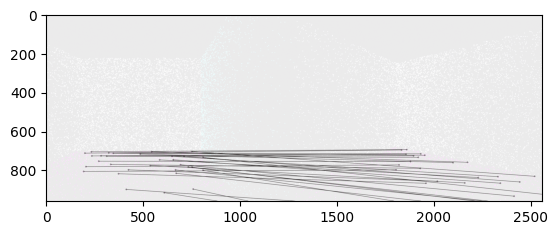

True

In [33]:
matches_img = draw_matches(new_frame_1, new_frame_2, rgb_img_1, rgb_img_2, 50)
plt.imshow(matches_img)
plt.show()
cv2.imwrite("./image_match.png", matches_img)

In [34]:
new_map = Map(new_frame_1, new_frame_2, T_world_from_cam_0=pose_at_time_1, scale=scale)

In [35]:
map_vis = new_map.get_visualization()

In [36]:
map_vis_gt = new_map.get_visualization_gt()

In [37]:
o3d.visualization.draw_geometries(map_vis)

In [ ]:
est_T_world_from_cam , _ = estimate_pose_essential_matrix(new_frame_2, new_frame_1, scale=scale)

In [ ]:
np.matmul(pose_at_time_1, est_T_world_from_cam)

In [ ]:
print(new_frame_1.T_world_from_cam_estimate)

In [ ]:
print(new_frame_2.T_world_from_cam_estimate)

In [ ]:
plt.imshow(rgb_img_1)
plt.show()

In [ ]:
plt.imshow(rgb_img_2)
plt.show()

In [ ]:
undistorted_observations_1 = (new_frame_1.undistorted_observations.values())
test_img_1 = draw_observations(undistorted_observations_1, camera.width, camera.height)
plt.imshow(test_img_1)
plt.show()
print(new_frame_1.distortion)

In [ ]:
test_img_2 = draw_observations(new_observations_2, camera.width, camera.height)
plt.imshow(test_img_2)
plt.show()

In [ ]:
print(len(new_observations))

In [ ]:
o3d.visualization.draw_geometries(new_frame_1.get_visualization() + new_frame_2.get_visualization())

In [ ]:
print(rgb_img)

In [ ]:
plt.imshow(rgb_img)
plt.show()
print(rgb_img.shape)

In [ ]:
test_scene_sampled_vis = test_scene.getSampledVisualization(500)
o3d.visualization.draw_geometries(test_scene_sampled_vis + test_vis)

In [ ]:
translate_up = np.eye(4)
translate_up[0:3, 3] = np.asarray([0.0, 0.0, 2.0])
interpolated_poses = interpolate_poses([0.0, 1.0], [np.eye(4), translate_up], [1.0])
print(interpolated_poses)

In [ ]:
interpolated_vis = visualize_poses(interpolated_poses)
print(len(interpolated_poses))

In [ ]:
o3d.visualization.draw_geometries(test_vis + interpolated_vis)

In [ ]:
rotation_spline = RotationSpline(test_timestamps, [Rotation.from_matrix(pose[0:3, 0:3]) for pose in test_poses])

In [ ]:
test_rot_matrices = [pose[0:3, 0:3] for pose in test_poses]
test_r = Rotation.from_matrix(test_rot_matrices)

In [ ]:
test_r.single

In [ ]:
rotation_spline = RotationSpline(test_timestamps, test_r)

In [ ]:
out_r = rotation_spline([1.5])

In [ ]:
for r in out_r:
    print(r)

In [ ]:
projection_matrix1 = np.array([[1, 0, 0, 0],
                                    [0, 1, 0, 0],
                                    [0, 0, 1, 0]])
    
projection_matrix1 = np.array(projection_matrix1, dtype=np.float64)

projection_matrix2 = np.array([[0.8, 0.2, 0.3, -1],
                                [0.1, 0.9, 0.4, 2],
                                [0.2, 0.1, 0.9, 3]])

# Create 3 arbitrary points
image_points1 = np.array([[10.0*i, 2.0*i] for i in range(4)])  # Image point in the first camera's image
image_points2 = np.array([[10.0*i, 2.0*i] for i in range(4)]) # Image point in the second camera's image

# Triangulate the 3D point
homogeneous_points = cv2.triangulatePoints(projection_matrix1, projection_matrix2, image_points1.T, image_points2.T)

cartesian_points = (homogeneous_points[:3, :] / homogeneous_points[3, :]).T

print("Triangulated 3D points")
print(cartesian_points)

In [ ]:
a = [(1, 1), (2, 2), (3, 3)]
print(np.asarray(a))
print(np.asarray([True, False, True])